# EMO task

In [ ]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

## Dependencies

In [ ]:
!pip install transformers -q
!pip install accelerate -U -q
!pip install datasets -q
!pip install torch-summary -q
!pip install graphviz -q
!pip install torchview -q
!pip install bertviz -q

repo_path = "https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/"
branch = "main"

In [ ]:
utils_url = f"{repo_path}{branch}/utils.py"
evaluation_url = f"{repo_path}{branch}/evaluation.py"

import os
if os.path.exists("utils.py"):
  !rm "utils.py"
if os.path.exists("evaluation.py"):
  !rm "evaluation.py"

!wget {utils_url}
!wget {evaluation_url}

--2023-07-06 21:42:00--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19809 (19K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  19.34K  --.-KB/s    in 0s      

2023-07-06 21:42:00 (123 MB/s) - ‘utils.py’ saved [19809/19809]

--2023-07-06 21:42:00--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/evaluation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10675 (10K) [text/pla

In [ ]:
import json
import torch
from torch import nn
from torch.nn import BCEWithLogitsLoss
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
from transformers import BertPreTrainedModel, BertModel
from transformers import RobertaModel,RobertaPreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput
import importlib
import sys
from utils import *
importlib.reload(sys.modules['utils'])

<module 'utils' from '/content/utils.py'>

In [ ]:
# set CUDA if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("======= CUDA Available =======")
else:
    device = torch.device('cpu')
    print("======= CUDA NOT Available, run on CPU =======")
device = torch.device('cpu') # otw goes out of memory

======= CUDA Available =======


## Dataset

Dataset paths

In [ ]:
TRAIN_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_internal_train_preproc.tsv" # f"{repo_path}{branch}/datasets/WASSA23_essay_level_internal_train_preproc.tsv"
VAL_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_internal_val_preproc.tsv"
DEV_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_dev_preproc.tsv"

Read dataframes

In [ ]:
train_df = pd.read_csv(TRAIN_DATA, sep='\t')
val_df = pd.read_csv(VAL_DATA, sep='\t')
dev_df = pd.read_csv(DEV_DATA, sep='\t')

In [ ]:
label_encoder = EmotionsLabelEncoder()
label_encoder.fit(train_df.emotion)

Optional subsample

In [ ]:
train_df = train_df
val_df = val_df
dev_df = dev_df

In [ ]:
y_train = label_encoder.encode(train_df.emotion)
y_val = label_encoder.encode(val_df.emotion)
y_dev = label_encoder.encode(dev_df.emotion)

Encode targets

In [ ]:
features_list = ['anger_count', 'disgust_count', 'fear_count', 'joy_count', 'sadness_count', 'surprise_count', 'hope_count']
features_train =  np.array(train_df[features_list])
features_val =  np.array(val_df[features_list])
features_dev =  np.array(dev_df[features_list])

## Model

In [ ]:
model_type ={
  'distilroberta-emotion':'j-hartmann/emotion-english-distilroberta-base',
  'roberta-emotion':'j-hartmann/emotion-english-roberta-large',
  'bert-base':'bert-base-cased'
}

In [ ]:
NUM_LABELS = 8

model_config = {
    'model_id': 'bert_lexicon',
    'tokenizer_name': model_type.get('bert-base'),
    'model_name': model_type.get('bert-base'),
    'train_batch_size': 4,
    'val_batch_size': 4,
    'learning_rate': 5e-5,
    'weight_decay': 0,
    'epochs': 10,
    'seed': 42,
    'patience': 10,
    'early_stopping_threshold': 0
} # TODO: expand...

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_config['tokenizer_name'], truncation=True)

**Baseline model**

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification")
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

**Custom "lexicon" Bert model**

In [ ]:
num_features=0# features_train.shape[1]
empathy_lexicon = True
distress_lexicon = True
emotion_lexicon = False
class BertPerWordLexiconPooling(BertPreTrainedModel):
  def __init__(self, config):
    super().__init__(config)
    self.num_labels = config.num_labels
    self.config = config
    self.n_features = num_features
    self.empathy = 1 if empathy_lexicon else 0
    self.distress = 1 if distress_lexicon else 0
    self.emotion = 7 if emotion_lexicon else 0
    self.bert = BertModel(config)
    self.dropout = nn.Dropout(0.3)
    self.classifier_layer1 = nn.Linear(config.hidden_size+self.n_features+self.empathy+self.distress+self.emotion,
                                       int((config.hidden_size+self.n_features+self.empathy+self.distress+self.emotion)/5))
    self.classifier_layer2 = nn.Linear(int((config.hidden_size+self.n_features+self.empathy+self.distress+self.emotion)/5), config.num_labels)
    self.tanh_layer = nn.Tanh()
    self.post_init()

  def forward(
    self,
    input_ids=None,
    attention_mask=None,
    token_type_ids=None,
    position_ids=None,
    head_mask=None,
    inputs_embeds=None,
    labels=None,
    output_attentions=None,
    output_hidden_states=None,
    return_dict=None,
    features=None,
    empathy_values=None,
    distress_values=None,
    emotion_values=None,
  ):
    return_dict = return_dict if return_dict is not None else self.config.use_return_dict

    outputs = self.bert(
      input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids,
      position_ids=position_ids,
      head_mask=head_mask,
      inputs_embeds=inputs_embeds,
      output_attentions=output_attentions,
      output_hidden_states=output_hidden_states,
      return_dict=return_dict,
    )

    # pooling
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
    sum_embeddings = torch.sum(outputs.last_hidden_state * input_mask_expanded, 1)
    sum_mask = input_mask_expanded.sum(1)
    sum_mask = torch.clamp(sum_mask, min = 1e-9)
    pooled_output = sum_embeddings/sum_mask

    # concat emotions values
    if empathy_values is not None:
      empathy_values_sum = torch.sum(empathy_values * attention_mask, 1)
      pooled_output = torch.cat(
          (
            pooled_output,
            empathy_values_sum.reshape(pooled_output.shape[0], 1)), dim=1)
    if distress_values is not None:
      distress_values_sum = torch.sum(distress_values * attention_mask, 1)
      pooled_output = torch.cat(
          (
            pooled_output,
            distress_values_sum.reshape(pooled_output.shape[0], 1)), dim=1)
    """if emotion_values is not None:
      emotion_values = emotion_values.permute(1, 0, 2)
      for emotion_value in emotion_values:
        emotion_value_sum = torch.sum(emotion_value * attention_mask, 1)
        pooled_output = torch.cat(
            (
              pooled_output,
              emotion_value_sum.reshape(pooled_output.shape[0], 1)), dim=1)"""

    # layer 1: dropout layer
    output_layer1 = self.dropout(pooled_output)
    if features is not None:
      # concat features
      output_layer1 = torch.cat((output_layer1, features), dim=0)

    # layer 2: classifier
    output_layer2 = self.classifier_layer1(output_layer1)

    # layer 3: tanh
    output_layer3 = self.tanh_layer(output_layer2)

    # layer 4: classifier
    output_layer4 = self.classifier_layer2(output_layer3)

    # compute loss
    logits = output_layer4
    loss = None
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits, labels)
    if not return_dict:
      output = (logits,) + outputs[2:]
      return ((loss,) + output) if loss is not None else output

    return SequenceClassifierOutput(
      loss=loss,
      logits=logits,
      hidden_states=outputs.hidden_states,
      attentions=outputs.attentions,
    )

In [ ]:
model = BertPerWordLexiconPooling.from_pretrained(model_type.get('bert-base'),num_labels=NUM_LABELS)
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertPerWordLexiconPooling: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertPerWordLexiconPooling from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertPerWordLexiconPooling from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertPerWordLexiconPooling were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classi

BertPerWordLexiconPooling(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [ ]:
class WASSADataset(Dataset):
    '''
    This class is used to create a pytorch dataset for the EMO task.
    '''

    def __init__(
        self,
        tokenizer,
        essay,
        targets,
        features=None, # np.array([[], []])
        essay_EMP_lexicon=None, # {'empathy': [, ... ,], 'ditress': [, ..., ]}
        essay_EMO_lexicon=None, # {'anger': [, ... ,], ..., 'sadness': [, ..., ]}
        ):
        self.tokenizer = tokenizer
        self.essay = essay
        self.targets = targets
        self.essay_EMP_lexicon = essay_EMP_lexicon
        self.essay_EMO_lexicon = essay_EMO_lexicon
        self.features = features

    def __len__(self):
        return len(self.essay)

    def __getitem__(self, index):
      essay = str(self.essay[index])
      inputs = tokenizer(
          text=essay,
          add_special_tokens=True,
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
          return_tensors='pt',
          return_token_type_ids=True
        )

      tokens_empathy = np.full(tokenizer.model_max_length, 4.0)
      tokens_distress = np.zeros(tokenizer.model_max_length)
      tokens_emotions = np.zeros((7, tokenizer.model_max_length))

      item = {
        'input_ids': inputs['input_ids'].flatten(),
        'attention_mask': inputs['attention_mask'].flatten(),
        'token_type_ids': inputs["token_type_ids"].flatten()
      }
      if self.features is not None:
        item['features'] = torch.FloatTensor(self.features[index])
      if self.targets is not None:
        item['labels'] = torch.FloatTensor(self.targets[index])
      if self.essay_EMP_lexicon is None and self.essay_EMO_lexicon is None:
        return item
      word_count=0
      first_char=True
      last_char_is_space=False
      for char_idx, char in enumerate(essay):
        token_idx = inputs.char_to_token(char_idx)
        if token_idx is None and not first_char:
          if not last_char_is_space:
            word_count+=1
            last_char_is_space=True
          continue
        elif last_char_is_space:
          last_char_is_space=False
        first_char=False
        if self.essay_EMP_lexicon is not None:
          tokens_empathy[token_idx] = self.essay_EMP_lexicon[index]['empathy'][word_count]
          tokens_distress[token_idx] = self.essay_EMP_lexicon[index]['distress'][word_count]
        if self.essay_EMO_lexicon is not None:
          for i, emotion in enumerate(self.essay_EMO_lexicon[index]):
            tokens_emotions[i][token_idx] = self.essay_EMO_lexicon[index][emotion][word_count]
      if self.essay_EMP_lexicon is not None:
        item['empathy_values'] = torch.FloatTensor(tokens_empathy)
        item['distress_values'] = torch.FloatTensor(tokens_distress)
      if self.essay_EMO_lexicon is not None:
        item['emotion_values'] = torch.FloatTensor(tokens_emotions)
      return item

In [ ]:
EMO_json_path_train = 'https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/lexicon/train_per_word_lexicon_EMO.json'
EMP_json_path_train = 'https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/lexicon/train_per_word_lexicon_EMP.json'
EMO_json_path_dev = 'https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/lexicon/dev_per_word_lexicon_EMO.json'
EMP_json_path_dev = 'https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/lexicon/dev_per_word_lexicon_EMP.json'
EMO_json_path_test = 'https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/lexicon/test_per_word_lexicon_EMO.json'
EMP_json_path_test = 'https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/lexicon/test_per_word_lexicon_EMP.json'

!wget {EMO_json_path_train}
!wget {EMP_json_path_train}
!wget {EMO_json_path_dev}
!wget {EMP_json_path_dev}
!wget {EMO_json_path_test}
!wget {EMP_json_path_test}

--2023-07-06 22:32:38--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/lexicon/train_per_word_lexicon_EMO.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3559244 (3.4M) [text/plain]
Saving to: ‘train_per_word_lexicon_EMO.json.18’

train_per_word_lexi 100%[===================>]   3.39M  --.-KB/s    in 0.03s   

2023-07-06 22:32:38 (102 MB/s) - ‘train_per_word_lexicon_EMO.json.18’ saved [3559244/3559244]

--2023-07-06 22:32:38--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/lexicon/train_per_word_lexicon_EMP.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.

In [ ]:
import json

with open('train_per_word_lexicon_EMO.json') as json_file:
  essay_EMO_lexicon_train_dict = json.load(json_file)
with open('train_per_word_lexicon_EMP.json') as json_file:
  essay_EMP_lexicon_train_dict = json.load(json_file)

with open('dev_per_word_lexicon_EMO.json') as json_file:
  essay_EMO_lexicon_dev_dict = json.load(json_file)
with open('dev_per_word_lexicon_EMP.json') as json_file:
  essay_EMP_lexicon_dev_dict = json.load(json_file)

with open('test_per_word_lexicon_EMO.json') as json_file:
  essay_EMO_lexicon_test_dict = json.load(json_file)
with open('test_per_word_lexicon_EMP.json') as json_file:
  essay_EMP_lexicon_test_dict = json.load(json_file)


In [ ]:
essay_EMP_lexicon_train = [essay_EMP_lexicon_train_dict[str(id)] for id in train_df['essay_id']]
essay_EMO_lexicon_train = [essay_EMO_lexicon_train_dict[str(id)] for id in train_df['essay_id']]

essay_EMP_lexicon_val = [essay_EMP_lexicon_train_dict[str(id)] for id in val_df['essay_id']]
essay_EMO_lexicon_val = [essay_EMO_lexicon_train_dict[str(id)] for id in val_df['essay_id']]

essay_EMP_lexicon_dev = [essay_EMP_lexicon_dev_dict[str(id)] for id in dev_df['essay_id']]
essay_EMO_lexicon_dev = [essay_EMO_lexicon_dev_dict[str(id)] for id in dev_df['essay_id']]

In [ ]:
train_set = WASSADataset(tokenizer=tokenizer, essay=train_df.essay, targets=y_train, features=None, essay_EMP_lexicon=essay_EMP_lexicon_train, essay_EMO_lexicon=essay_EMO_lexicon_train)
val_set = WASSADataset(tokenizer=tokenizer, essay=val_df.essay, targets=y_val, features=None, essay_EMP_lexicon=essay_EMP_lexicon_val, essay_EMO_lexicon=essay_EMO_lexicon_val)
dev_set = WASSADataset(tokenizer=tokenizer, essay=dev_df.essay, targets=y_dev, features=None, essay_EMP_lexicon=essay_EMP_lexicon_dev, essay_EMO_lexicon=essay_EMO_lexicon_dev)

## Training

Prepare datasets

In [ ]:
"""train_set = EMODataset(tokenizer=tokenizer, essay=train_df.essay, targets=y_train)#, features=features_train)
val_set = EMODataset(tokenizer=tokenizer, essay=val_df.essay, targets=y_val)#, features=features_val)
dev_set = EMODataset(tokenizer=tokenizer, essay=dev_df.essay, targets=y_dev)#, features=features_dev)"""

'train_set = EMODataset(tokenizer=tokenizer, essay=train_df.essay, targets=y_train)#, features=features_train)\nval_set = EMODataset(tokenizer=tokenizer, essay=val_df.essay, targets=y_val)#, features=features_val)\ndev_set = EMODataset(tokenizer=tokenizer, essay=dev_df.essay, targets=y_dev)#, features=features_dev)'

In [ ]:
"""train_set = EMODataset(tokenizer=tokenizer, essay=train_df.essay, targets=y_train, features=features_train)
val_set = EMODataset(tokenizer=tokenizer, essay=val_df.essay, targets=y_val, features=features_val)
dev_set = EMODataset(tokenizer=tokenizer, essay=dev_df.essay, targets=y_dev, features=features_dev)"""

'train_set = EMODataset(tokenizer=tokenizer, essay=train_df.essay, targets=y_train, features=features_train)\nval_set = EMODataset(tokenizer=tokenizer, essay=val_df.essay, targets=y_val, features=features_val)\ndev_set = EMODataset(tokenizer=tokenizer, essay=dev_df.essay, targets=y_dev, features=features_dev)'

Set up training

In [ ]:
train_arguments = TrainingArguments(
    output_dir=f"./{model_config['model_name']}",
    per_device_train_batch_size=model_config['train_batch_size'],
    per_device_eval_batch_size=model_config['val_batch_size'],
    num_train_epochs=model_config['epochs'],
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps = 300,
    save_steps = 300,
    learning_rate=model_config['learning_rate'],
    weight_decay=model_config['weight_decay'],
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    seed=model_config['seed'],
    logging_strategy = "epoch"
) # TODO: custom other params

In [ ]:
trainer = Trainer(
    model=model,
    args=train_arguments,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=tokenizer,
    compute_metrics=compute_EMO_metrics_trainer
)

Callbacks

In [ ]:
class TrainerLoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero: # whether this process is the main one in a distributed setting
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=model_config['patience'],
    early_stopping_threshold=model_config['early_stopping_threshold']))

trainer.add_callback(TrainerLoggingCallback(model_config['model_id']+"_log.json"))

Start training

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Sklearn Accuracy,Roc Auc Micro,Accuracy,Micro Precision,Micro Recall,Micro F,Macro Precision,Macro Recall,Macro F
300,0.538900,0.354705,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
600,0.338200,0.320118,0.012346,0.505128,0.010256,1.000000,0.010256,0.020305,0.125000,0.003333,0.006494
900,0.306200,0.305188,0.351852,0.672969,0.330233,0.780220,0.364103,0.496503,0.097527,0.118333,0.106928
1200,0.289900,0.304495,0.339506,0.664368,0.313364,0.755556,0.348718,0.477193,0.094444,0.113333,0.103030
1500,0.279100,0.302055,0.327160,0.658492,0.305164,0.783133,0.333333,0.467626,0.097892,0.108333,0.102848


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

TrainOutput(global_step=1550, training_loss=0.3319778762325164, metrics={'train_runtime': 672.5186, 'train_samples_per_second': 9.174, 'train_steps_per_second': 2.305, 'train_loss': 0.3319778762325164, 'epoch': 10.0})

In [ ]:
# Access the training logs
train_logs = trainer.state.log_history

# Extract the loss values from the logs
train_loss_values = [log.get('loss') for log in train_logs if log.get('loss') is not None]
eval_loss_values = [log.get('eval_loss') for log in train_logs if log.get('eval_loss') is not None]
train_epochs = [log.get('epoch') for log in train_logs if log.get('loss') is not None]
eval_epochs = [log.get('epoch') for log in train_logs if log.get('eval_loss') is not None]

In [ ]:
train_logs

[{'loss': 0.5389, 'learning_rate': 4.5e-05, 'epoch': 1.0, 'step': 155},
 {'eval_loss': 0.3547051250934601,
  'eval_sklearn_accuracy': 0.0,
  'eval_roc_auc_micro': 0.5,
  'eval_accuracy': 0.0,
  'eval_micro_precision': 0.0,
  'eval_micro_recall': 0.0,
  'eval_micro_f': 0.0,
  'eval_macro_precision': 0.0,
  'eval_macro_recall': 0.0,
  'eval_macro_f': 0.0,
  'eval_runtime': 5.8632,
  'eval_samples_per_second': 27.63,
  'eval_steps_per_second': 6.993,
  'epoch': 1.94,
  'step': 300},
 {'loss': 0.3931, 'learning_rate': 4e-05, 'epoch': 2.0, 'step': 310},
 {'loss': 0.3382, 'learning_rate': 3.5e-05, 'epoch': 3.0, 'step': 465},
 {'eval_loss': 0.32011833786964417,
  'eval_sklearn_accuracy': 0.012345679012345678,
  'eval_roc_auc_micro': 0.5051282051282051,
  'eval_accuracy': 0.010256410256410256,
  'eval_micro_precision': 1.0,
  'eval_micro_recall': 0.010256410256410256,
  'eval_micro_f': 0.020304568527918784,
  'eval_macro_precision': 0.125,
  'eval_macro_recall': 0.0033333333333333335,
  'eval_

In [ ]:
plot_loss_curve(train_loss_values, eval_loss_values, loss_epochs, eval_epochs,"loss", f"{model_config['model_name']}_loss.png")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'loss_epochs' is not defined

## Evaluation

In [ ]:
def predict_emotions(results, gold_emotions):

  binarized_predictions = np.where(results.predictions >= 0.5, 1, 0)

  for i, bin_pred in enumerate(binarized_predictions):
    if np.all(bin_pred==0):
      binarized_predictions[i][np.argmax(results.predictions[i])] = 1

  predicted_emotions = label_encoder.decode(binarized_predictions)
  return predicted_emotions


In [ ]:
trainer.state.best_model_checkpoint

'./bert-base-cased/checkpoint-1500'

In [ ]:
outs = trainer.predict(dev_set)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
gold_emotions = gold_emotions = label_encoder.decode(outs.label_ids)
predicted_emotions = predict_emotions(outs, gold_emotions)

In [ ]:
write_EMO_predictions(predicted_emotions, model_config['model_id']+"_predictions_EMO.tsv")
challenge_metrics = compute_EMO_metrics(golds=gold_emotions, predictions=predicted_emotions)
write_dict_to_json(challenge_metrics, model_config['model_id']+"_dev_metrics.json")
challenge_metrics

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'micro_recall': 0.5407,
 'micro_precision': 0.6394,
 'micro_f': 0.5859,
 'macro_recall': 0.2131,
 'macro_precision': 0.1574,
 'macro_F': 0.1783,
 'accuracy': 0.4143}

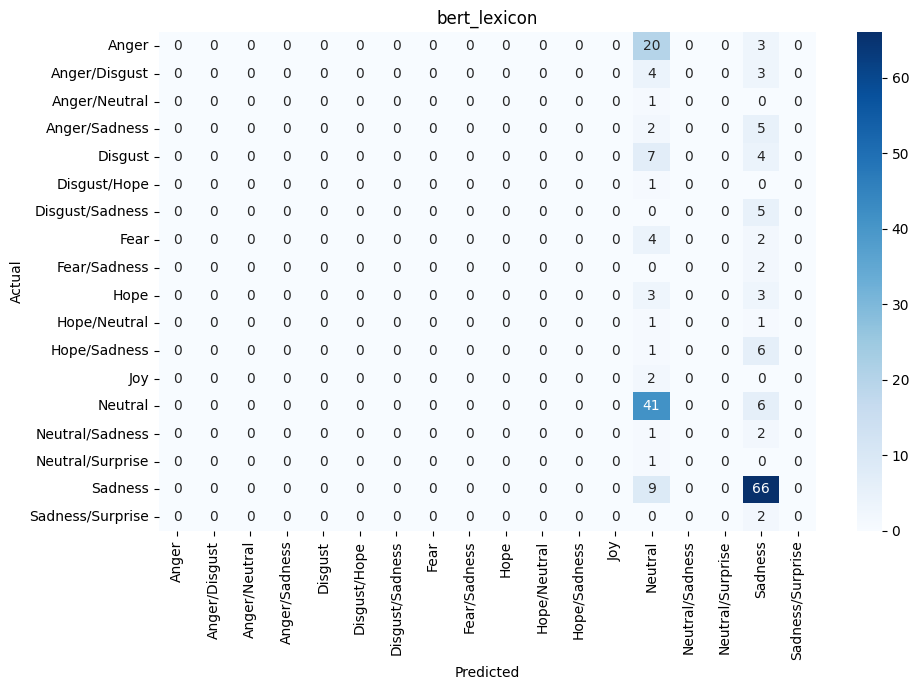

In [ ]:
plot_confusion_matrix(golds=gold_emotions, predictions=predicted_emotions, path=model_config['model_id']+"_confusion_matrix.pdf", title=model_config['model_id'])

In [ ]:
plot_model_graph(model=model, input_data=tokenizer("Hello world!", return_tensors="pt"), path=model_config['model_id']+"_graph")

In [ ]:
print_model_summary(model=model, path=model_config['model_id']+"_summary.txt")

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               22,268,928
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Linear: 1-3                            118,734
├─Linear: 1-4                            1,240
├─Tanh: 1-5                              --
Total params: 108,430,246
Trainable params: 108,430,246
Non-trainable params: 0


In [ ]:
len(predicted_emotions)

208

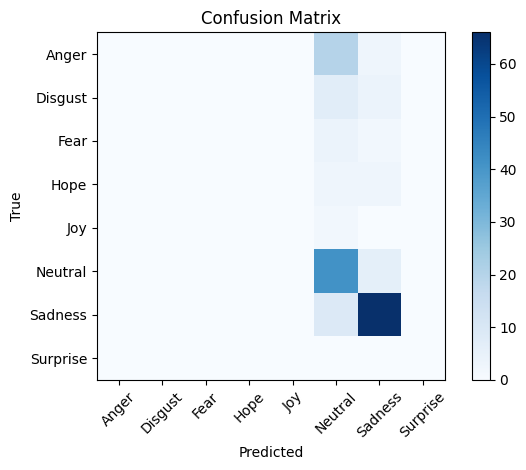

In [ ]:
# Define the desired label names
label_names = ['Anger', 'Disgust', 'Fear', 'Hope', 'Joy', 'Neutral', 'Sadness', 'Surprise']

# Compute the confusion matrix
cm = confusion_matrix(gold_emotions, predicted_emotions, labels=label_names)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Customize the plot
ax.set_xticks(np.arange(len(label_names)))
ax.set_yticks(np.arange(len(label_names)))
ax.set_xticklabels(label_names, rotation=45)
ax.set_yticklabels(label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.tight_layout()
plt.show()

## Save model on Google Drive

In [ ]:
#trainer.state.best_model_checkpoint

In [ ]:
#!mv $trainer.state.best_model_checkpoint /content/drive/MyDrive/hlt

## Inference

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/hlt/best-roberta"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification")

load checkpoint

In [ ]:
# Load the checkpoint file
checkpoint_file = "./bert-base-cased/checkpoint-1200"
#model = AutoModelForSequenceClassification.from_pretrained(checkpoint_file, num_labels=NUM_LABELS)
model = BertLexicon.from_pretrained(checkpoint_file, num_labels=NUM_LABELS)
trainer = Trainer(model=model)
# Perform prediction using the loaded checkpoint
predictions = trainer.predict(dev_set)

In [ ]:
gold_emotions = label_encoder.decode(predictions.label_ids)
predicted_emotions = predict_emotions(predictions, gold_emotions)

In [ ]:
write_EMO_predictions(predicted_emotions, model_config['model_id']+"_predictions_EMO.tsv")
challenge_metrics = compute_EMO_metrics(golds=gold_emotions, predictions=predicted_emotions)
write_dict_to_json(challenge_metrics, model_config['model_id']+"_dev_metrics.json")
challenge_metrics